# City of Philadelphia Licenses and Inspections Appeals <a id='top'></a>

The dataset contains decisions of Philadelphia Licenses and Inspections Appeal Board. The dataset contains 28869 records and 37 columns.

Several columns such as Appeal Grounds, Related Permits and Proviso are in Natural Language format. 

Source: https://www.opendataphilly.org/dataset/license-and-inspections-appeals/resource/b721ad52-9e27-46d2-b494-6bf0ef1c7603?inner_span=True

### I would like to research the relationship of the board decision stored in the column 'decision' and other values in the dataset such as Appeal Grounds(NL), Related Permits(NL), Proviso(NL) and well as property address(geospatial).


## Table of Content

[Load and review the data](#Load-and-review-the-data)  
[Loading necessary packages](#Loading-necessary-packages)  
[Clear out Null values](#Clear-out-Null-values)  
[Remove /PROV value from decision column and store it as a flag in a separate field](#Remove-/PROV-value-from-decision-column-and-store-it-as-a-flag-in-a-separate-field)  
[Translate appeal decision into new feature and reduce the number of outcomes](#Translate-appeal-decision-into-new-feature-and-reduce-the-number-of-outcomes)  
[Dataset Centroids and distances from them](#Dataset-Centroids-and-distances-from-them)  
[Distances from Landmarks](#Distances-from-Landmarks)  
[Scatter Plot Map](#Scatter-Plot-Map)  
[Appeal Grounds](#Appeal-Grounds)  
[myMetrics Function for model testing](#myMetrics-Function-for-model-testing)  
[Pre-processing and Test/Train Split](#Pre-processing-and-Test/Train-Split)  
[Final Hypertable](#Final-Hypertable)

### Loading necessary packages  <a id='Loading-necessary-packages'></a>

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline
from pandas_profiling import ProfileReport
import string

from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics #metrics module


import warnings
warnings.filterwarnings('ignore')

hypertable=[]

### Load and review the data <a id='Load-and-review-the-data'></a> 
[(back to the top)](#top)

In [2]:
#Database URL
url = 'https://phl.carto.com/api/v2/sql?q=SELECT+*,+ST_Y(the_geom)+AS+lat,+ST_X(the_geom)+AS+lng+FROM+appeals&filename=appeals&format=csv&skipfields=cartodb_id'
#Initial Dataset load
df = pd.read_csv(url, low_memory=False)

In [3]:
#Sample data
df.head()

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng
0,0101000020E610000037BAFB2B1DC352C03A158AB3C90A...,0101000020110F000083B7668792DE5FC1D7531E50DD9B...,8,716319.0,8940 KREWSTOWN RD,NaN,118,19115-4517,888630077.0,646106,...,2010-05-04 13:15:00,MOOT,NaN,COMPLIED,2010-05-04 00:00:00,HANSEN,2.724252e+06,285119.162422,40.084280,-75.048656
1,0101000020E61000003690253716C852C06DEBA50163FD...,0101000020110F00008ED1ECEB04E75FC16710A3FAFF8C...,9,628798.0,2300 E YORK ST,NaN,NaN,19125-2120,313145500.0,363094,...,2009-10-28 17:00:00,GRANTED,NaN,NaN,2009-10-28 00:00:00,HANSEN,2.703654e+06,246341.440497,39.979584,-75.126356
2,0101000020E61000003C08EF26A0CB52C03BDF48F08D06...,0101000020110F0000E86105BF07ED5FC1EBBBD9912A97...,10,531963.0,128 E SHARPNACK ST,NaN,NaN,19119-2237,221108000.0,313082,...,2009-12-29 13:15:00,MOOT,NaN,COMPLIED,2009-12-30 00:00:00,HANSEN,2.687406e+06,271965.871360,40.051207,-75.181650
3,0101000020E61000000E3A31E95AC552C0FDEF06071902...,0101000020110F000085E81E1561E25FC16F05D2083992...,11,297984.0,4671 FRANKFORD AVE,NaN,NaN,19124-5827,871529760.0,565329,...,2009-10-06 09:30:00,GRANTED,NaN,NaN,2009-10-06 00:00:00,HANSEN,2.715205e+06,260100.891162,40.016389,-75.083674
4,0101000020E6100000926D2397A0CE52C05ED5D7D893FB...,0101000020110F0000A996150421F25FC15C0150B0FE8A...,12,589254.0,5421 VINE ST,NaN,NaN,19139-2041,41034400.0,511115,...,2009-12-29 13:15:00,WITHDRAWN,NaN,NaN,2009-10-21 00:00:00,HANSEN,2.675173e+06,240360.419544,39.965449,-75.228552


In [4]:
#Number of rows and features
print("df.shape", df.shape)

df.shape (29739, 37)


In [5]:
#Column Names
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng'],
      dtype='object')

In [6]:
#General Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29739 entries, 0 to 29738
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   the_geom              29121 non-null  object 
 1   the_geom_webmercator  29121 non-null  object 
 2   objectid              29739 non-null  int64  
 3   addressobjectid       29164 non-null  float64
 4   address               29152 non-null  object 
 5   unit_type             100 non-null    object 
 6   unit_num              553 non-null    object 
 7   zip                   29152 non-null  object 
 8   opa_account_num       28012 non-null  float64
 9   parcel_id_num         28482 non-null  object 
 10  censustract           29123 non-null  float64
 11  opa_owner             28685 non-null  object 
 12  primaryappellant      29739 non-null  object 
 13  appellanttype         29036 non-null  object 
 14  internaljobid         27715 non-null  float64
 15  appealnumber       

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

### Clear out Null values <a id='Clear-out-Null-values'></a>
[(back to the top)](#top)

I am dropping records with Null value in Decision column. They represent less than 10% of the data. With the multitude of unique values in that column I can't decide what value I can replace it with.

In [7]:
df = df[~df['decision'].isna()]
df[df['systemofrecord'].isna()]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng


In [8]:
#df.nunique()/df.shape[0]
df[df['decision'].isna()].shape[0]/df.shape[0]

0.0

In [9]:
df[df['lat'].isna()].shape[0]

18

I'm dropping these as well.

In [10]:
df = df[~df['lat'].isna()]

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

In [11]:
#Percent of unique values per values per column
df.nunique()/df.shape[0]

the_geom                0.801373
the_geom_webmercator    0.801373
objectid                1.000000
addressobjectid         0.815957
address                 0.804696
unit_type               0.000148
unit_num                0.004320
zip                     0.486340
opa_account_num         0.775419
parcel_id_num           0.771838
censustract             0.014103
opa_owner               0.706380
primaryappellant        0.457321
appellanttype           0.000295
internaljobid           0.974341
appealnumber            1.000000
acceleratedappeal       0.000074
createddate             0.998597
completeddate           0.448534
relatedpermit           0.980765
relatedcasefile         0.000295
appealstatus            0.000295
appealtype              0.000443
agendadescription       0.000074
applicationtype         0.000258
meetingnumber           0.025659
appealgrounds           0.922838
scheduleddate           0.174371
decision                0.001181
meetingresult           0.000222
proviso   

In [12]:
df.dtypes

the_geom                 object
the_geom_webmercator     object
objectid                  int64
addressobjectid         float64
address                  object
unit_type                object
unit_num                 object
zip                      object
opa_account_num         float64
parcel_id_num            object
censustract             float64
opa_owner                object
primaryappellant         object
appellanttype            object
internaljobid           float64
appealnumber             object
acceleratedappeal        object
createddate              object
completeddate            object
relatedpermit            object
relatedcasefile          object
appealstatus             object
appealtype               object
agendadescription        object
applicationtype          object
meetingnumber            object
appealgrounds            object
scheduleddate            object
decision                 object
meetingresult            object
proviso                  object
decision

Clean Data Types

In [13]:
df['createddate'] = pd.to_datetime(df['createddate'])

In [14]:
df['completeddate'] = pd.to_datetime(df['completeddate'])
df['scheduleddate'] = pd.to_datetime(df['scheduleddate'])
df['decisiondate'] = pd.to_datetime(df['decisiondate'])

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

#### Cleaning  Application Type column

In [15]:
#Top examples of "applicationtype"
df['applicationtype'].value_counts().head(10)

RB_ZBA                         19042
RB_LIRB                         5587
RB_BBS                          1762
Zoning Board of Adjustment       651
Board of Building Standards       39
Plumbing Advisory Board            4
L&I Review Board Codes             1
Name: applicationtype, dtype: int64

Instead of using abbreviated values for Application Types lets rename them in fully spelled values

In [16]:
df['applicationtype'][df['applicationtype'] == 'RB_ZBA'] = 'Zoning Board of Adjustment'
df['applicationtype'][df['applicationtype'] == 'RB_LIRB'] = 'L&I Review Board Codes'
df['applicationtype'][df['applicationtype'] == 'RB_BBS'] = 'Board of Building Standards'

In [17]:
#Top examples of "appealgrounds"
df['applicationtype'].value_counts().head(10)

Zoning Board of Adjustment     19693
L&I Review Board Codes          5588
Board of Building Standards     1801
Plumbing Advisory Board            4
Name: applicationtype, dtype: int64

Lets drop Plumbing Advisory Board records as an outlier 

In [18]:
df = df[~(df['applicationtype'] == 'Plumbing Advisory Board')]

In [19]:
#Top examples of "appealgrounds"
df['applicationtype'].value_counts().head(10)

Zoning Board of Adjustment     19693
L&I Review Board Codes          5588
Board of Building Standards     1801
Name: applicationtype, dtype: int64

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

##### New Lawyer column showing if the owner is represented by a lawyer

In [20]:
df['primaryappellant'].value_counts().head(30)

SHAWN D. WARD, ESQUIRE          421
ZHEN JIN                        287
JOSEPH BELLER, ESQ.             254
DAVID ORPHANIDES, ESQ.          238
SHAWN WARD, ESQ.                228
RONALD PATTERSON, ESQ.          225
ALAN NOCHUMSON, ESQ.            198
RUSTIN OHLER                    182
BEDITZA CADILLO                 170
BRETT D. FELDMAN, ESQUIRE       165
VERN ANASTASIO, ESQ             162
STEPHEN G. POLLOCK, ESQUIRE     158
CARL PRIMAVERA, ESQUIRE         150
LEO MULVIHILL, JR., ESQ.        147
HENRY M. CLINTON, ESQ           143
DAVID G. ORPHANIDES, ESQUIRE    132
JOSEPH BELLER, ESQUIRE          131
ZHEN H. JIN, ESQ                114
RICHARD DEMARCO, ESQ.           113
JOSEPH BELLER, ESQ              110
HAROLD MURRAY                   110
MICHAEL MATTIONI                103
ZHEN H. JIN, ESQUIRE             96
ADAM E. LAVER, ESQUIRE           95
DARWIN R. BEAUVAIS, ESQUIRE      94
RONALD J. PATTERSON, ESQ         91
NEIL SKLAROFF, ESQUIRE           87
THOMAS CITRO                

It's clear that the top names must be the names of lawyers representing their clients, but without having an ESQ or ESQUIRE suffix, I can't tell for sure.

In [21]:
#Create new column showing that the Owner is represented by a lawyer 
# TODO change to regular expression, use NLP
def lawyer(appellant):
    if 'esq' in appellant.lower():
        return 1
    else:
        return 0
df['lawyer'] = df['primaryappellant'].apply(lawyer)


&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

In [22]:
#Top examples of "appealgrounds"
df['appealgrounds'].value_counts().head(20)

PERMIT FOR TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                                                                                                                                                                                                                         111
PERMIT FOR A TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                                                                                                                                                                                                                        65
WE ARE APPEALING THE ISSUANCE OF BUILDING PERMIT #765070 FOR HEALTH AND ENVIRONMENTAL CONCERNS.                                                                                                                                                                                                       63
PERMIT FOR THREE (3) FAMILY DWELLING (MULTI-FAMILY DWELLING) IN AN EXISTING STRUCTURE.                       

In [23]:
pd.Series(df['relatedpermit'].value_counts().head(5).index.values).str.split("\n", expand=True).stack()

0  0            Description of Project:  SM/LRG FOOD ESTAB
   1                                      APPEAL TYPES==> 
   2                             APPEAL TYPE: LI-REFGRNT  
   3                                                      
   4                                   BOARD DECISIONS==> 
   5     DECISION: CONTINUED  DECDATE: 16-OCT-18  PROVI...
   6                                                      
   7                                     COURT APPEALS==> 
   8                                                      
1  0      Description of Project:  BUILDING PERMIT #765070
   1                                      APPEAL TYPES==> 
   2                             APPEAL TYPE: AGAINSTL&I  
   3                                                      
   4                                   BOARD DECISIONS==> 
   5     DECISION: AFFIRMED  DECDATE: 28-JUL-17  PROVIS...
   6                                                      
   7                                     COURT APPEALS==

In [24]:
#Top value of "proviso"
df['proviso'].value_counts().head(10)

COMPLIED                                                          1751
FOR WANT OF APPEARANCE                                             737
*****CASE WITHDRAWN.*****                                          402
*****CASE DISMISSED.*****                                          163
*****CASE DISMISSED - PUT INTO ENFORCEMENT.*****                   109
60 DAY STAY OF ENFORCEMENT                                         101
90 DAY STAY OF ENFORCEMENT                                          85
30 DAY STAY OF ENFORCEMENT                                          58
WITHOUT PREJUDICE;  CITY HAS THE RIGHT TO RE-ISSUE VIOLATIONS.      54
120 DAY STAY OF ENFORCEMENT                                         53
Name: proviso, dtype: int64

#### Cleaning Decision column

In [25]:
#Breakdown by decision
df['decision'].value_counts()

GRANTED         8436
GRANTED/PROV    6260
WITHDRAWN       2420
MOOT            2283
AFFIRMED        1956
DENIED          1796
APPROVED        1554
DISMISSED        936
Granted          530
SUSTAINED        255
CONTINUED        224
Withdrawn         81
DENIED/PROV       69
ADMIN/REVIEW      63
DISMI/ENFORC      42
REMAND            38
Approved          36
Denied            31
HELD              17
NEWHEARNOT        12
Refused           10
HELD/INFO          9
BOARDAKNOWL        7
LATE-APPRVD        3
REFUSED            3
REVISED            2
Dismissed          2
LATE-DENIED        2
NEWHEARYES         2
RESCHEDULE         1
ISSUED             1
Revised            1
Name: decision, dtype: int64

In [26]:
# Save the values
df['decisionsv']=df['decision']

In [27]:
df[(df['decision'].str.contains('/PROV') == True) & (df['proviso'].isna() == True)][['decision', 'proviso']]

,decision,proviso
3403,DENIED/PROV,NaN
25556,GRANTED/PROV,NaN


Even though there are only two records, it appears that /PROV in the 'decision' field doesn't mean that there is value in the field 'proviso'

In [28]:
df[~(df['decision'].str.contains('/PROV') == True) & (df['proviso'].isna() == False)][['decision', 'proviso']]

,decision,proviso
0,MOOT,COMPLIED
2,MOOT,COMPLIED
9,AFFIRMED,CITY WILL STAY ENFORCEMENT FOR 60 DAYS TO SECU...
21,AFFIRMED,CITY WILL STAY ENFORCEMENT ACTION FOR 90 DAYS.
22,MOOT,COMPLIED
...,...,...
29545,Granted,With Proviso: Previously Approved Uses To Remain
29677,Granted,MAXIMUM 17 UNITS
29687,Granted,"With proviso: Revised plans, 2 pages, approved..."
29688,Granted,With proviso: Commercial trash pickup.


not having /PROV in 'decision' field doesn't mean no value in 'provision'

#### Remove /PROV value from decision column and store it as a flag in a separate field
[(back to the top)](#top)

In [29]:
# Add new field prvFlag to store "/PROV" from decision
df['provFlag'] = (df['decision'].str.contains('/PROV') == True).astype('int')

In [30]:
df[df['decision'].str.contains('/PROV')]['decision'].str.len().unique()

array([12, 11], dtype=int64)

In [31]:
def stripProviso (decision):
    if '/PROV' in decision:
        strLength = len(decision)
        return decision[0: strLength-5]
    else:
        return decision

In [32]:
df['decision'] = df['decision'].apply(stripProviso)

In [33]:
df[['decision','decisionsv','provFlag']]

,decision,decisionsv,provFlag
0,MOOT,MOOT,0
1,GRANTED,GRANTED,0
2,MOOT,MOOT,0
3,GRANTED,GRANTED,0
4,WITHDRAWN,WITHDRAWN,0
...,...,...,...
29688,Granted,Granted,0
29691,Denied,Denied,0
29692,Granted,Granted,0
29704,Granted,Granted,0


### Change case for all decisions to lower case

In [34]:
df['decision'] = df['decision'].str.lower()

### Combine dismissed and withdrawn as dismissed

In [35]:
sorted(df[df['decision'].str.contains('dismi')]['decision'].unique())

['dismi/enforc', 'dismissed']

In [36]:
def dismissed (decision):
    if 'dismi' in decision or decision == 'withdrawn':
        return 'dismissed'
    else:
        return decision

In [37]:
df['decision'] = df['decision'].apply(dismissed)

In [38]:
sorted(df[df['decision'].str.contains('dismi')]['decision'].unique())

['dismissed']

In [39]:
sorted(df['decision'].unique())

['admin/review',
 'affirmed',
 'approved',
 'boardaknowl',
 'continued',
 'denied',
 'dismissed',
 'granted',
 'held',
 'held/info',
 'issued',
 'late-apprvd',
 'late-denied',
 'moot',
 'newhearnot',
 'newhearyes',
 'refused',
 'remand',
 'reschedule',
 'revised',
 'sustained']

In [40]:
df['decision'].value_counts()

granted         15226
dismissed        3481
moot             2283
affirmed         1956
denied           1896
approved         1590
sustained         255
continued         224
admin/review       63
remand             38
held               17
refused            13
newhearnot         12
held/info           9
boardaknowl         7
revised             3
late-apprvd         3
newhearyes          2
late-denied         2
issued              1
reschedule          1
Name: decision, dtype: int64

In [41]:
df[(df['decision'] == 'complete')]['meetingresult'].value_counts()

Series([], Name: meetingresult, dtype: int64)

In [42]:
df[(df['decision'] == 'continued')]['meetingresult'].value_counts()

Series([], Name: meetingresult, dtype: int64)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
### Reduce the number of decision choices
[(back to the top)](#top)

In [43]:
def translateComplete(meetingresult):
    switcher = {
        'Granted':'approved',
        'Denied':'denied',
        'Withdrawn':'other',
        'Dismissed':'denied',
        'Approved':'approved',
        'Refused':'denied'                
        }
    return switcher.get(meetingresult, 'other') 

#def CompleteDecision(decision, meetingresult):
def CompleteDecision(arg):
    if arg[0] == 'complete':
        return translateComplete(arg[1])
    else:
        return arg[0]

    
def funcNewDecision(decision): 
    switcher = {
        'admin/review': 'other',
        'affirmed':'denied',
        'approved':'approved',
        'boardaknowl':'other',
        'cancelled':'other',
        'complete':'complete',
        'continued':'other',
        'denied':'denied',
        'dismissed':'other',
        'granted':'approved',
        'held':'denied',
        'held/info':'denied',
        'issued':'other',
        'late-apprvd':'other',
        'late-denied':'other',
        'moot':'other',
        'newhearnot':'other',
        'newhearyes':'other',
        'refused':'denied',
        'remand':'other',
        'reschedule':'other',
        'rescheduled':'other',
        'revised':'other',
        'sustained':'denied'
        } 
    return switcher.get(decision, 'other') 

df['decision'].apply(funcNewDecision).value_counts()

df[df['decision'] == 'complete']['meetingresult'].apply(translateComplete).value_counts()

df[['decision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision).value_counts()

#df['newDecision'] = df[df['decision'] == 'complete'][['newDecision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision).value_counts()


granted         15226
dismissed        3481
moot             2283
affirmed         1956
denied           1896
approved         1590
sustained         255
continued         224
admin/review       63
remand             38
held               17
refused            13
newhearnot         12
held/info           9
boardaknowl         7
revised             3
late-apprvd         3
newhearyes          2
late-denied         2
issued              1
reschedule          1
dtype: int64

In [44]:
df['decision'] = df['decision'].apply(funcNewDecision)
df['decision'] = df[['decision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision)
df['decision'].value_counts()

approved    16816
other        6120
denied       4146
Name: decision, dtype: int64

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬

In [45]:
pd.set_option('display.max_colwidth', None)
df[df['decisionsv'] == 'HELD/INFO'].head(5)

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag
4165,0101000020E6100000CCF7447DB4CD52C0B3F0B9DC37F84340,0101000020110F0000B4D87CF98FF05FC10B2C36E745875241,3714,622915.0,5000-40 WOODLAND AVE,NaN,NaN,19143-5100,773182100.0,145910,...,FOR TAX CERT,2011-04-13,HANSEN,2.679485e+06,230919.547094,39.939205,-75.214141,1,HELD/INFO,0
6937,0101000020E61000000BDC3CA74DCA52C06FEFAEB9B0034440,0101000020110F000051F299C5C8EA5FC1D48F1C31FD935241,6817,398758.0,34 E LOGAN ST,NaN,NaN,19144-3017,121004500.0,343791,...,VOTE IN 2 WEEKS; APPLICANT & COMMUNITY TO MEET RE: PARKING ISSUES; LETTER TO ZBA 2 WEEKS,2008-08-19,HANSEN,2.693426e+06,263987.075341,40.028831,-75.160990,1,HELD/INFO,0
9642,0101000020E610000009FB5E34FECA52C0CB57E0F6A8F44340,0101000020110F0000F7F87AA9F4EB5FC1A043E81B55835241,9888,51909.0,3101 S BROAD ST,NaN,NaN,19148-5239,395370400.0,183090,...,VOTE 3/18/08; HOLD FOR 5-PAGE SUMMARY FROM EACH SIDE.,2008-03-20,HANSEN,2.691658e+06,221141.422866,39.911406,-75.171765,1,HELD/INFO,0
19685,0101000020E6100000DDCDED235ECB52C058A5DB6590F74340,0101000020110F000000615C9E97EC5FC1D3290B698C865241,19943,671302.0,1400 S 20TH ST,NaN,NaN,19146-4507,871549280.0,25999,...,HELD 60 DAYS PENDING REVISED REFUSAL FROM L&I & RCO MEETING/COUNCIL PERSON,2020-01-22,HANSEN,2.689776e+06,229354.773235,39.934094,-75.177621,0,HELD/INFO,0
20753,0101000020E6100000ACCC8E97F4C952C02A4FBFD171004440,0101000020110F000026FB0C7E31EA5FC143D33AC363905241,20303,660781.0,3259 N 16TH ST,NaN,NaN,19140-4910,112194800.0,250252,...,letter from RCO and C/W,2019-02-06,HANSEN,2.695219e+06,254798.523686,40.003473,-75.155554,0,HELD/INFO,0


In [46]:
df[df['proviso'].isnull() == True]
df[(df['decisionsv'].str.contains("PROV") == True) & (df['decision'] != 'approved')  & (df['proviso'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag
3403,0101000020E610000069E5342373C952C01F08D7D608034440,0101000020110F00008650D49955E95FC113DBDCFC42935241,3074,50852.0,4623 N BROAD ST,NaN,NaN,19140-1217,491542000.0,308137,...,NaN,2008-06-10,HANSEN,2.697214e+06,262231.253452,40.023707,-75.147652,1,DENIED/PROV,1


In [47]:
df[df['meetingresult'].isnull() == False]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag
49,0101000020E610000012821833D5CA52C07F2461F5DAFC4340,0101000020110F0000B64DCD02AFEB5FC12485D831698C5241,53,127982554.0,2000 SEYBERT ST,NaN,NaN,19121-4817,291053500.0,37094,...,NaN,2020-09-10 19:28:54,ECLIPSE,2.691679e+06,244475.379312,39.975432,-75.169263,1,Granted,0
147,0101000020E610000034792585E7CA52C0BE2C08CA1CF64340,0101000020110F00006A2F5321CEEB5FC1A0EB61D8F0845241,141,15509740.0,2212 S BROAD ST,NaN,NaN,19145-3923,773016950.0,1471482,...,\r\nThe Board of Building Standards has denied the variance.,2020-10-02 13:03:15,ECLIPSE,2.691926e+06,225284.576692,39.922754,-75.170381,0,Refused,0
183,0101000020E6100000C059FE156BCE52C0825CB53C96054440,0101000020110F000074021B22C6F15FC1D9F1A2C117965241,210,15545853.0,531 LIVEZEY ST,NaN,NaN,19128-2419,213345552.0,338238,...,NaN,2020-11-30 14:40:49,ECLIPSE,2.675274e+06,268861.081608,40.043647,-75.225286,0,Granted,0
249,0101000020E61000004D7BC1E443CA52C0663B07BF14FC4340,0101000020110F000075A8AD31B8EA5FC12ED763878D8B5241,239,15453232.0,842 N BROAD ST,NaN,NaN,19130-2234,882885597.0,464788,...,NaN,2020-10-09 11:02:37,ECLIPSE,2.694228e+06,242345.549053,39.969383,-75.160394,0,Granted,0
273,0101000020E6100000B692B43A1FC952C0593D2949E3FC4340,0101000020110F000010520913C7E85FC19B51786C728C5241,274,15456898.0,1618 GERMANTOWN AVE,NaN,NaN,19122-3017,183160510.0,436927,...,"With proviso: (1) revised plans, 1 pg., approved today.",2020-10-14 11:31:12,ECLIPSE,2.699165e+06,244787.950990,39.975686,-75.142531,0,Granted,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29688,0101000020E61000001D74C93C2ECA52C0BBEA6BA4C1FF4340,0101000020110F0000067AB06893EA5FC112F2966FA08F5241,29564,129914270.0,2900-12 N 17TH ST,NaN,NaN,19132-2228,881427020.0,502086,...,With proviso: Commercial trash pickup.,2020-12-13 20:11:53,ECLIPSE,2.694291e+06,252811.869025,39.998097,-75.159072,0,Granted,0
29691,0101000020E6100000ADFD74DAEBBD52C002EB9FFD050B4440,0101000020110F00000F68388CC0D55FC1D33B053D209C5241,29567,128397521.0,4501 WOODHAVEN RD,NaN,NaN,19154-3145,NaN,495596,...,NaN,2020-12-23 12:02:12,ECLIPSE,2.746923e+06,286493.835007,40.086120,-74.967520,0,Denied,0
29692,0101000020E6100000F6C86439EDCE52C0D733A5FBFCF94340,0101000020110F0000FF44AA2FA3F25FC1CD3CE0DF3B895241,29568,15916120.0,5525 LARCHWOOD AVE,NaN,NaN,19143-1313,604137100.0,449721,...,NaN,2020-12-22 18:03:36,ECLIPSE,2.673991e+06,235801.751436,39.953033,-75.233229,0,Granted,0
29704,0101000020E6100000402B3D6B52CA52C043BBF53F39FF4340,0101000020110F0000A16BE5DDD0EA5FC19E21913A098F5241,29573,15332536.0,1800 W GLENWOOD AVE,NaN,NaN,19132-3825,871522470.0,474398,...,"With proviso (1) trash to be stored in yard; (2) roof mounted exhaust; (3) commercial trash pick up; and (4) hours of operation: Sunday thru Thursday 10am to 11pm, Friday and Saturday 10 am to midnight.",2020-12-22 16:40:54,ECLIPSE,2.693717e+06,251278.101360,39.993935,-75.161280,0,Granted,0


In [48]:
(df['decision'] + " - " + df['meetingresult']).value_counts()

approved - Complete              520
other - Dismissed / Withdrawn     43
denied - Complete                 35
approved - Request Review         15
other - Complete                  11
other - Cancelled                  3
denied - Request Review            3
approved - Continued               2
denied - Rescheduled               1
dtype: int64

In [49]:
df[(df['decision']=='Complete') & (df['meetingresult'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,lawyer,decisionsv,provFlag


In [50]:
df[(df['decision']=='approved') & (~df['proviso'].isnull())].head(2).T

,11,12
the_geom,0101000020E6100000AF9F68DBCDCB52C09FA1095A7B064440,0101000020E6100000C622E4E4AAC752C012749513E2FF4340
the_geom_webmercator,0101000020110F00004C85746155ED5FC1A74786F215975241,0101000020110F0000E62423A04EE65FC19120F964C48F5241
objectid,19,20
addressobjectid,310443,608597
address,6643 GERMANTOWN AVE,523 E WESTMORELAND ST
unit_type,NaN,NaN
unit_num,NaN,NaN
zip,19119-2253,19134-1735
opa_account_num,8.71528e+08,8.71513e+08
parcel_id_num,424826,296064


In [51]:
df['appealstatus'].value_counts()

CLOSED                   14331
OPEN                     12060
In Process                 412
Completed                  217
Waiting Period              34
Dismissed / Withdrawn       12
Scheduled                   12
Prepare Meeting              4
Name: appealstatus, dtype: int64

In [52]:
df[df['appealstatus'].isin(['CLOSED','Completed','Dismissed / Withdrawn','Closed'])]['decision'].value_counts()

approved    10638
other        2418
denied       1504
Name: decision, dtype: int64

In [53]:
df['censustract'].describe().T

count    27082.000000
mean       249.594036
std        926.323610
min          1.000000
25%         42.020000
50%        149.000000
75%        259.000000
max       9891.000000
Name: censustract, dtype: float64

In [54]:
#df.nunique()/df.shape[0]
df[df['decision'].isna()].shape[0]/df.shape[0]

0.0

#### Dataset Centroids and distances from them
[(back to the top)](#top)

In [55]:
df[['lat','lng']].agg([min,max, 'mean']).T

,min,max,mean
lat,39.880338,40.137052,39.984461
lng,-75.274212,-74.961283,-75.153741


In [56]:
centers = df[df['decision'].isin(['approved','denied'])].groupby(['decision'])['lng','lat'].mean()
centers.loc['general'] = df[['lng','lat']].mean()
centers

,lng,lat
decision,,
approved,-75.153253,39.980678
denied,-75.155191,39.992003
general,-75.153741,39.984461


In [57]:
for name in 'approved denied general'.split():
    squared = (df['lng'] - centers.loc[name]['lng'])**2 + (df['lng'] - centers.loc[name]['lat'])**2
    df['from_' + name + '_center'] =   (squared)**0.5
    df['from_' + name + '_center_Sq'] = squared


In [58]:
df[['from_approved_center_Sq','from_denied_center_Sq','from_general_center_Sq']].head()

,from_approved_center_Sq,from_denied_center_Sq,from_general_center_Sq
0,13231.758574,13234.364517,13232.628901
1,13249.630048,13252.237450,13250.500887
2,13262.362642,13264.971082,13263.233845
3,13239.809954,13242.416554,13240.680512
4,13273.172336,13275.781655,13274.043847


#### Distances from Landmarks
[(back to the top)](#top)

In [59]:
landmarks = {}

#Save Philadelphia Center City Latitude and Longitude.
landmarks['CC'] = (39.952583, -75.165222)
CC_Lat = 39.952583
CC_Lng = -75.165222

# South Philadelphia High School
landmarks['South'] = (39.9236, -75.1684)
South_Lat = 39.9236 
South_Lng = -75.1684

#Philadelphia County Assistance Office Delancey District
landmarks['West'] = (39.9610, -75.2366)
West_Lat = 39.9610
West_Lng = -75.2366

#Frankford Transportation Center
landmarks['NE'] = (40.0234, -75.0772)
NE_Lat = 40.0234
NE_Lng = -75.0772

In [60]:
(lat,lng) = landmarks['CC']
lat

39.952583

In [61]:

#create "distance" from center city 
for name in 'CC South West NE'.split():
    (lat, lng) = landmarks[name]
    squared = (df['lat']-lat)**2 + (df['lng']-lng)**2
    df['from' + name] = (squared)**0.5
    df['from' + name + '_Sq'] = squared

In [62]:
df[['fromCC', 'fromCC_Sq', 'fromSouth', 'fromWest', 'fromNE']].head(5)

,fromCC,fromCC_Sq,fromSouth,fromWest,fromNE
0,0.175875,0.030932,0.200392,0.224769,0.067240
1,0.047325,0.002240,0.070014,0.111799,0.065849
2,0.099982,0.009996,0.128293,0.105626,0.108088
3,0.103544,0.010721,0.125651,0.162648,0.009543
4,0.064623,0.004176,0.073278,0.009196,0.162067


In [63]:
df[['from_general_center', 'from_general_center_Sq', 'from_approved_center', 'from_denied_center']].head(5)

,from_general_center,from_general_center_Sq,from_approved_center,from_denied_center
0,115.033164,13232.628901,115.029381,115.040708
1,115.110820,13250.500887,115.107037,115.118363
2,115.166114,13263.233845,115.162332,115.173656
3,115.068156,13240.680512,115.064373,115.075699
4,115.213037,13274.043847,115.209255,115.220578


In [64]:
df['fromCC'].agg(['max','min'])

max    0.252279
min    0.000070
Name: fromCC, dtype: float64

In [65]:
df[['lat','geocode_y']].corr()

,lat,geocode_y
lat,1.000000,0.999754
geocode_y,0.999754,1.000000


In [66]:
df[['lng','geocode_x']].corr()

,lng,geocode_x
lng,1.000000,0.999596
geocode_x,0.999596,1.000000


It appears that geocode_y has strong correlation with latitude as well as geocode_x with longitude. 

In [67]:
try:
    os.mkdir('images')
except:
    print('directory already exists')

directory already exists


In [68]:
df['decision'].unique()

array(['other', 'approved', 'denied'], dtype=object)

### Scatter Plot Map
[(back to the top)](#top)

In [69]:
centers

,lng,lat
decision,,
approved,-75.153253,39.980678
denied,-75.155191,39.992003
general,-75.153741,39.984461


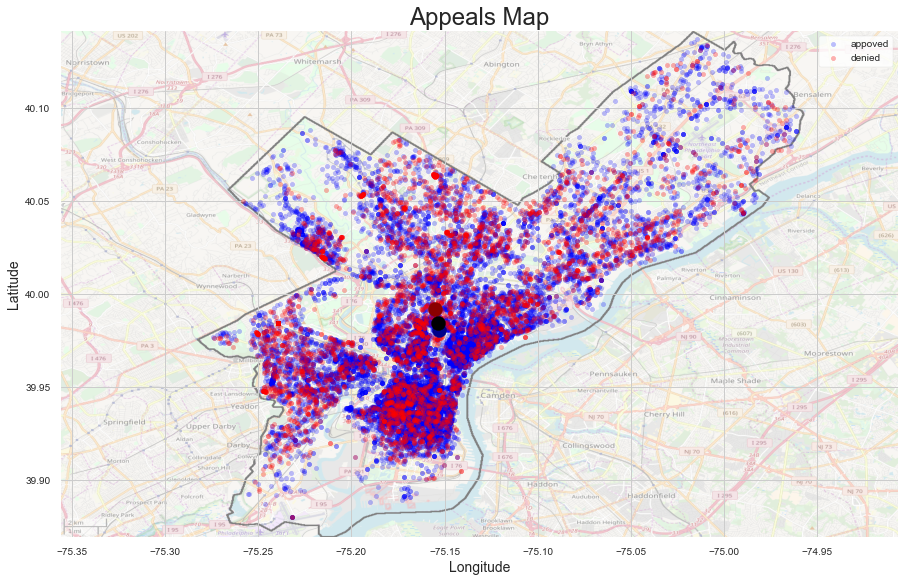

In [70]:
import numpy as np
import matplotlib.image as mpimg
philadelphia_img=mpimg.imread('images/Street_map_of_Philadelphia_and_surrounding_area.png')

plt.axes
plt.figure(figsize=(15,15))
plt.title('Appeals Map', size=24)
plt.rc('font', size=24)

plt.imshow(philadelphia_img, extent=[-75.356, -74.9066, 39.8694, 40.1414], alpha=0.5)

dfscat = df[df['decision'] == 'approved']
plt.scatter(dfscat['lng'], dfscat['lat'], marker = 'o', label = 'appoved', s=20, alpha=0.25, c='blue')

dfscat = df[df['decision'] == 'denied']
plt.scatter(dfscat['lng'], dfscat['lat'], marker = 'o', label = 'denied', s=20, alpha=0.3, c='red')

plt.scatter(centers.loc['denied']['lng'], centers.loc['denied']['lat'], c='darkred', s=200, alpha=1)
plt.scatter(centers.loc['approved']['lng'], centers.loc['approved']['lat'], c='darkblue', s=200, alpha=1)
plt.scatter(centers.loc['general']['lng'], centers.loc['general']['lat'], c='black', s=200, alpha=1)

plt.grid('on')
plt.legend()
plt.rc('font', size=18)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

plt.savefig('images/appeal_map.png',bbox_inches='tight')
plt.show() 

<AxesSubplot:>

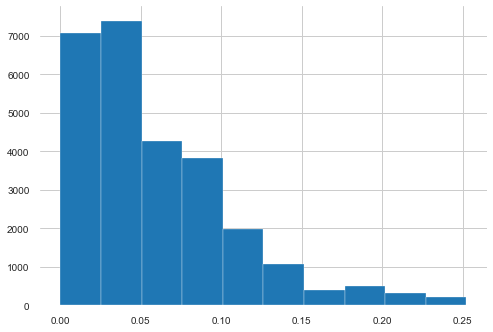

In [71]:
#Distance from CC
df['fromCC'].hist()

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

#### Appeal Grounds
[(back to the top)](#top)

In [72]:
df['appealgrounds'] = df['appealgrounds'].str.lower()

In [73]:
#remove punctuation
df['appealgrounds'] = df['appealgrounds'].str.replace('[{}]'.format(string.punctuation), '')

In [74]:
df[df['appealgrounds'].isna()]['appealgrounds'].shape

(14,)

In [75]:
#dropping 14 records that have null for appealgrounds
df = df[~df['appealgrounds'].isna()]
#TODO use fillna with blank

In [76]:
df['appealgrounds'] = df['appealgrounds'].apply(word_tokenize)

In [77]:
df['appealgrounds'].head(10)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [we, are, an, owner, occupied, condominium]
1                                                                                                                                                                                                                                                                                                                                                       [permit, for, the, retail, sale, of, satellite, dish, on, the, first, f

In [78]:
from gensim.models import Word2Vec
print(Word2Vec.__doc__)

Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/.

    Once you're finished training a model (=no more updates, only querying)
    store and use only the :class:`~gensim.models.keyedvectors.KeyedVectors` instance in `self.wv` to reduce memory.

    The model can be stored/loaded via its :meth:`~gensim.models.word2vec.Word2Vec.save` and
    :meth:`~gensim.models.word2vec.Word2Vec.load` methods.

    The trained word vectors can also be stored/loaded from a format compatible with the
    original word2vec implementation via `self.wv.save_word2vec_format`
    and :meth:`gensim.models.keyedvectors.KeyedVectors.load_word2vec_format`.

    Some important attributes are the following:

    Attributes
    ----------
    wv : :class:`~gensim.models.keyedvectors.Word2VecKeyedVectors`
        This object essentially contains the mapping between words and embeddings. After training, it can be used
        directly to query those embeddings in various ways. S

In [79]:
from collections import Counter


In [ ]:
from sklearn import tfidf

In [80]:
#counter = Counter(df['appealgrounds'])

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

### myMetrics Function for model testing
[(back to the top)](#top)

In [81]:
# Create metrics function to check metrics for different models

def myMetrics(model=None, sample=None, features=None, X_test=None, y_true_test=None, X_train=None, y_true_train=None):
    
    hypertablerow={}
    hypertablerow['model'] = model.__class__.__name__
    #print("Model:", model.__class__.__name__)
    hypertablerow['sample'] = sample + ' sample'
    hypertablerow['features'] = features

    X_train_temp = X_train[features]
    X_test_temp = X_test[features]  
    #print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    #print("y_pred_test.value_counts:", pd.Series(y_pred_test).value_counts())
    #print("y_pred_train.value_counts:", pd.Series(y_pred_train).value_counts())

    # F1 score
    hypertablerow['f1_score_test'] = metrics.f1_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    #print('f1_score_test', hypertablerow['f1_score_test'])
    hypertablerow['f1_score_train'] = metrics.f1_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    #print('f1_score_train', hypertablerow['f1_score_train'])
    # Accuracy
    hypertablerow['accuracy_test'] = metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test)
    #print('accuracy_test', hypertablerow['accuracy_test'])
    hypertablerow['accuracy_train'] = metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train)
    #print('accuracy_train', hypertablerow['accuracy_train'])
    # Precision
    hypertablerow['precision_test'] = metrics.precision_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    hypertablerow['precision_train'] = metrics.precision_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    # Recall
    hypertablerow['recall_test'] = metrics.recall_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    hypertablerow['recall_train'] = metrics.recall_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')

    hypertable.append(hypertablerow)
    pd.Series(hypertablerow)
    return hypertablerow

### Create "dummy" variables for applicationtype column

In [82]:
# Create "dummy" variables for applicationtype columns
df = pd.concat([df, pd.get_dummies(df['applicationtype'])], axis=1)
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng', 'lawyer', 'decisionsv',
       'provFlag', 'from_approved_center', 'from_approved_center_Sq',
       'from_denied_center', 'from_denied_center_Sq', 'from_general_center',
       'from_general_center_Sq', 'fromCC', 'fromCC_Sq', 'fromSouth',
       'fromSouth_Sq', 'fromWest', 'fromWest_Sq', 'fromNE', 'fromNE_Sq',
       'Board of Building Standards', 'L&I Review Board 

I am planning to oversample and undersample the original dataset.
To be able to compare the results of the original dataset with oversample and undersample I am creating two sets for the X and y as well as the list of sample names.

In [83]:
X = {}
y = {}
samples = ['original', 'under', 'over']

In [84]:
# Declare an explanatory variable, and assign some data to it 
X['original'] = df.drop(['decision'], axis=1)

# Declare a response variable, the decision column of the df 
y['original'] = df['decision'] 

In [85]:
X['original'].columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'meetingresult',
       'proviso', 'decisiondate', 'systemofrecord', 'geocode_x', 'geocode_y',
       'lat', 'lng', 'lawyer', 'decisionsv', 'provFlag',
       'from_approved_center', 'from_approved_center_Sq', 'from_denied_center',
       'from_denied_center_Sq', 'from_general_center',
       'from_general_center_Sq', 'fromCC', 'fromCC_Sq', 'fromSouth',
       'fromSouth_Sq', 'fromWest', 'fromWest_Sq', 'fromNE', 'fromNE_Sq',
       'Board of Building Standards', 'L&I Review Board Codes',
    

### Pre-processing and Test/Train Split
[(back to the top)](#top)

In [86]:
#UnderSampling

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
rus.fit(X['original'], y['original'])

X['under'], y['under'] = rus.fit_resample(X['original'], y['original'])

In [87]:
#OverSampling

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
ros.fit(X['original'], y['original'])

X['over'], y['over'] = ros.fit_resample(X['original'], y['original'])

In [88]:
# import the preprocessing package
from sklearn import preprocessing
X_train = {}
X_test = {}
y_train = {}
y_test = {}

# Call the train_test_split() function
# Declare four variables, X_train, X_test, y_train and y_test separated by commas 
for sample in samples:
    X_train[sample], X_test[sample], y_train[sample], y_test[sample] = \
    train_test_split(X[sample], y[sample], test_size=0.25, random_state=1)

In [89]:
for sample in samples:
    print('\n' + sample + ' sample')
    print('X_train.shape',X_train[sample].shape)
    print('X_test.shape',X_test[sample].shape)
    print('y_train.size', y_train[sample].size)
    print('y_test.size', y_test[sample].size)
    print('y_train.value_counts',y_train[sample].value_counts())
    print('y_train.describe', y_test[sample].value_counts())


original sample
X_train.shape (20301, 56)
X_test.shape (6767, 56)
y_train.size 20301
y_test.size 6767
y_train.value_counts approved    12574
other        4596
denied       3131
Name: decision, dtype: int64
y_train.describe approved    4230
other       1523
denied      1014
Name: decision, dtype: int64

under sample
X_train.shape (9326, 56)
X_test.shape (3109, 56)
y_train.size 9326
y_test.size 3109
y_train.value_counts denied      3134
other       3103
approved    3089
Name: decision, dtype: int64
y_train.describe approved    1056
other       1042
denied      1011
Name: decision, dtype: int64

over sample
X_train.shape (37809, 56)
X_test.shape (12603, 56)
y_train.size 37809
y_test.size 12603
y_train.value_counts approved    12615
denied      12601
other       12593
Name: decision, dtype: int64
y_train.describe other       4211
denied      4203
approved    4189
Name: decision, dtype: int64


### Testing LinearSVC model

In [90]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#model = GaussianNB()
#model = KNeighborsClassifier(n_neighbors=10)
model = svm.LinearSVC() # Linear Kernel
#model = svm.SVC(kernel='poly') # Linear Kernel
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    print('y_true_test.value_counts()', y_true_test.value_counts())

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  
    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'fromCC']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))


features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment','fromCC', 'censustract']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

y_true_test.value_counts() approved    4230
other       1523
denied      1014
Name: decision, dtype: int64
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    5386
other       1381
dtype: int64
y_pred_train.describe: approved    16094
other        4207
dtype: int64
Test Accuracy 0.7493719521205852
Train Accuracy 0.7442983104280577
y_true_test.value_counts() approved    1056
other       1042
denied      1011
Name: decision, dtype: int64
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    2009
other       1100
dtype: int64
y_pred_train.describe: approved    5945
other       3381
dtype: int64
Test Accuracy 0.5229977484721775
Train Accuracy 0.5137250696976196
y_true_test.value_counts() other       4211
denied      4203
approved    4189
Na

In [91]:
model = svm.LinearSVC() # Linear Kernel
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment','fromCC', 'censustract']

y_true_train = y_train['over']
y_true_test = y_test['over']

X_train_temp = X_train['over'][features]
X_test_temp = X_test['over'][features]  

#    print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

y_pred_test.describe: approved    10350
other        2253
dtype: int64
y_pred_train.describe: approved    30817
other        6992
dtype: int64
Test Accuracy 0.42037610092835037
Train Accuracy 0.42680314210902165


In [92]:
from sklearn.metrics import confusion_matrix

In [93]:
np.set_printoptions(precision=2)

cm = confusion_matrix(y_true=y_true_test.to_numpy(), y_pred=y_pred_test)


In [94]:
cm

array([[4188,    0,    1],
       [3061,    0, 1142],
       [3101,    0, 1110]], dtype=int64)

In [95]:
y_true_test.value_counts()

other       4211
denied      4203
approved    4189
Name: decision, dtype: int64

In [96]:
pd.Series(y_pred_test).value_counts()

approved    10350
other        2253
dtype: int64

It appears that Linear SVC model even when oversampled returns very poor test result - no values in "denied" class.

### Testing KNeighborsClassifier model

In [97]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
#model = KNeighborsClassifier(n_neighbors=10)
#model = svm.LinearSVC() # Linear Kernel
model = svm.SVC(kernel='poly', degree=2) # Poy Kernel - takes VERY LONG time
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    print('y_true_test.value_counts()', y_true_test.value_counts())

    print("Model:", model.__class__.__name__)

    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  
    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())

    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'fromCC']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))


features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment','fromCC', 'censustract']

for sample in samples:
    y_true_train = y_train[sample]
    y_true_test = y_test[sample]
    X_train_temp = X_train[sample][features]
    X_test_temp = X_test[sample][features]  

    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.describe:", pd.Series(y_pred_test).value_counts())
    print("y_pred_train.describe:", pd.Series(y_pred_train).value_counts())


    print('Test Accuracy', metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test))
    print('Train Accuracy', metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train))

y_true_test.value_counts() approved    4230
other       1523
denied      1014
Name: decision, dtype: int64
Model: SVC
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    5386
other       1381
dtype: int64
y_pred_train.describe: approved    16094
other        4207
dtype: int64
Test Accuracy 0.7493719521205852
Train Accuracy 0.7442983104280577
y_true_test.value_counts() approved    1056
other       1042
denied      1011
Name: decision, dtype: int64
Model: SVC
X_train_temp.columns: Index(['Board of Building Standards', 'L&I Review Board Codes',
       'Zoning Board of Adjustment'],
      dtype='object')
y_pred_test.describe: approved    2009
other       1100
dtype: int64
y_pred_train.describe: approved    5945
other       3381
dtype: int64
Test Accuracy 0.5229977484721775
Train Accuracy 0.5137250696976196
y_true_test.value_counts() other       4211
denied      42

### Confusion Matrix

In [98]:
y_true_test.value_counts()

other       4211
denied      4203
approved    4189
Name: decision, dtype: int64

Confusion matrix, without normalization
[[   0 4153   36]
 [   0 4173   30]
 [   0 4167   44]]
Normalized confusion matrix
[[0.   0.99 0.01]
 [0.   0.99 0.01]
 [0.   0.99 0.01]]


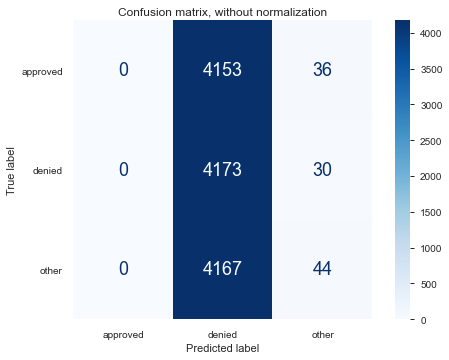

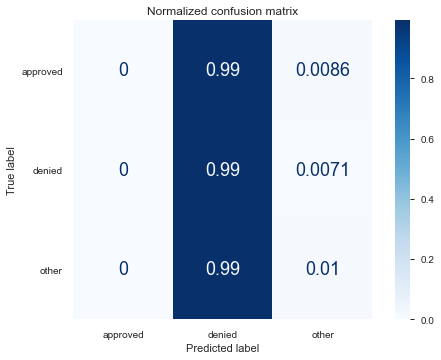

In [99]:
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test_temp, y_true_test,
#                                 display_labels=y_true_test.sort_values().unique(),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


### LogisticRegression
[(back to the top)](#top)

In [100]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [101]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [102]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [103]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [104]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [105]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [106]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer', 
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
         'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [107]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [108]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center',
         'from_approved_center_Sq', 'from_denied_center_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### KNeighborsClassifier Model

In [109]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [110]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [111]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [112]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [113]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [114]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [115]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [116]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [117]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE', 
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq', 
          'from_approved_center', 'from_denied_center',
         'from_approved_center_Sq', 'from_denied_center_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### Gaussian Naive Bayes Model

In [118]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [119]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [120]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [121]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [122]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [123]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### Random Forrest Classifier Model

In [124]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.datasets import make_classification
model = RandomForestClassifier(max_depth= 5, random_state= 1234)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [125]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.datasets import make_classification
model = RandomForestClassifier(max_depth= 5, random_state= 1234)
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [126]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [127]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

### Decision Tree Classifier

In [128]:
from sklearn import tree

model = tree.DecisionTreeClassifier(criterion="gini", max_depth = 5, random_state = 1234)

features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

In [129]:
features=['Board of Building Standards', 'L&I Review Board Codes', 'Zoning Board of Adjustment', 'lawyer',
          'fromCC', 'from_general_center', 'fromSouth', 'fromWest', 'fromNE',
          'fromCC_Sq', 'fromSouth_Sq', 'fromWest_Sq', 'fromNE_Sq']
for sample in samples:
    hypertablerow = myMetrics(model=model,sample=sample,features=features,
                              X_train=X_train[sample],y_true_train=y_train[sample],
                              X_test=X_test[sample],y_true_test=y_test[sample])

## Final Hypertable
[(back to the top)](#top)

In [130]:
pd.DataFrame(hypertable).to_csv('hypertable.csv')
dfhypertable = pd.DataFrame(hypertable).sort_values('precision_test')
pd.set_option('display.max_colwidth', -1)
pd.set_option("max_rows", None)
dfhypertable.round(3).sort_values('f1_score_test', ascending=False)

,model,sample,features,f1_score_test,f1_score_train,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train
42,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, from_approved_center, from_denied_center]",0.704,0.736,0.739,0.766,0.704,0.746,0.739,0.766
9,LogisticRegression,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center]",0.703,0.690,0.745,0.735,0.706,0.689,0.745,0.735
12,LogisticRegression,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE]",0.702,0.690,0.746,0.736,0.704,0.689,0.746,0.736
48,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center]",0.702,0.736,0.738,0.766,0.702,0.746,0.738,0.766
36,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center]",0.701,0.735,0.737,0.765,0.701,0.745,0.737,0.765
51,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq, from_approved_center, from_denied_center, from_approved_center_Sq, from_denied_center_Sq]",0.700,0.731,0.737,0.762,0.701,0.741,0.737,0.762
33,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC]",0.699,0.732,0.737,0.763,0.698,0.743,0.737,0.763
39,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE]",0.698,0.738,0.734,0.767,0.697,0.747,0.734,0.767
45,KNeighborsClassifier,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC, from_general_center, fromSouth, fromWest, fromNE, fromCC_Sq, fromSouth_Sq, fromWest_Sq, fromNE_Sq]",0.698,0.738,0.734,0.767,0.697,0.747,0.734,0.767
6,LogisticRegression,original sample,"[Board of Building Standards, L&I Review Board Codes, Zoning Board of Adjustment, lawyer, fromCC]",0.697,0.687,0.733,0.725,0.695,0.683,0.733,0.725
